In [1]:
import sys
sys.path.append('..')

import os
import numpy as np
import pandas as pd
from sklearn import decomposition
from caffeine import EEGProcessing
from matplotlib import pyplot as plt
from scipy import stats, ndimage, signal

In [2]:
CAF_DOSE = 200

SUBJECT_INDEX = 0
CLEAN_STAGE = 'REM'

SUBJECTS_PATH = 'E:\\Cafeine_data\\CAF_{dose}_Inventaire.csv'.format(dose=CAF_DOSE)
EEG_PATH = 'E:\\Cafeine_data\\CAF_{dose}\\EEG_data\\'.format(dose=CAF_DOSE)
EOG_PATH = 'C:\\Users\\Philipp\\Documents\\Caffeine\\EOG{dose}'.format(dose=CAF_DOSE)

STAGES = ['AWA', 'NREM', 'REM']

In [3]:
subjects = pd.read_csv(SUBJECTS_PATH, index_col=0)

print('Loading EEG data...')
eeg_path = os.path.join(EEG_PATH, subjects['Subject_id'][SUBJECT_INDEX], 'EEG_data_clean.npy')
eeg = np.load(eeg_path)

print('Loading EOG data...')
eog_path = os.path.join(EOG_PATH, subjects['Subject_id'][SUBJECT_INDEX] + '_EOG.npy')
eog = np.load(eog_path)

print('Loading hypnogram...')
hypnogram_path = os.path.join(EEG_PATH, subjects['Subject_id'][SUBJECT_INDEX], 'hyp_clean.npy')
hypnogram = np.load(hypnogram_path)

combined = np.concatenate([eeg, eog], axis=0)
data = EEGProcessing.extract_sleep_stages(combined, hypnogram)

Loading EEG data...
Loading EOG data...
Loading hypnogram...


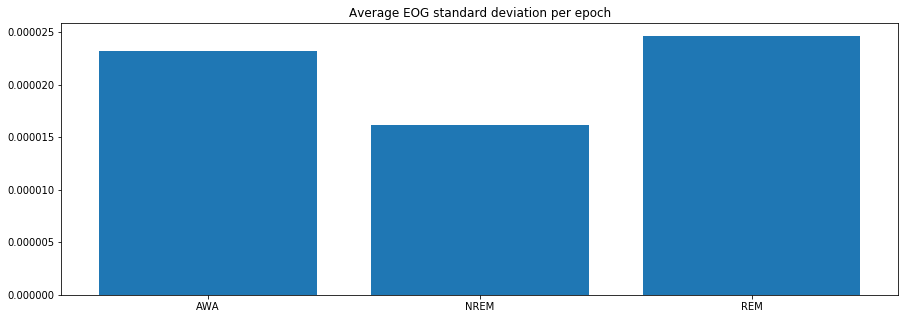

In [4]:
stds = []
for stage in STAGES:
    stds.append(np.mean([data[stage][-2:,:,i].std(axis=1) for i in range(data[stage].shape[2])]))

plt.figure(figsize=(15, 5))
plt.title('Average EOG standard deviation per epoch')
plt.bar(np.arange(len(stds)), stds)
plt.xticks(np.arange(len(STAGES)), STAGES)
plt.show()

In [5]:
stage_epochs = []
for epoch in range(data[CLEAN_STAGE].shape[2]):
    stage_epochs.append(data[CLEAN_STAGE][:,:,epoch])
    
stage = np.concatenate(stage_epochs, axis=1).T
stage = stats.zscore(stage, axis=1)

epoch_length = data[CLEAN_STAGE].shape[1]
normalized = np.empty(data[CLEAN_STAGE].shape)
for epoch in range(data[CLEAN_STAGE].shape[2]):
    normalized[:,:,epoch] = stage[epoch*epoch_length:(epoch+1)*epoch_length].T

pca = decomposition.PCA()
transformed = pca.fit_transform(stage)

In [6]:
correlation = np.empty((transformed.shape[1], 2))
for i in range(transformed.shape[1]):
    correlation[i,0] = np.corrcoef(stage[:,-2], transformed[:,i])[0,1]
    correlation[i,1] = np.corrcoef(stage[:,-1], transformed[:,i])[0,1]
    
best_eog1_comp = np.argmax(correlation[:,0])
best_eog2_comp = np.argmax(correlation[:,1])

print('EOG correlation with PCA components:')
print(pd.DataFrame({'EOG 1': correlation[:,0], 'EOG 2': correlation[:,1]}))

EOG correlation with PCA components:
           EOG 1         EOG 2
0   6.867691e-01  2.891090e-01
1   7.132836e-01 -4.933791e-01
2   2.236081e-02  7.406954e-01
3   1.274279e-01  2.894139e-01
4  -4.926516e-02  1.969677e-01
5   9.642355e-03 -3.400767e-02
6   1.622653e-02 -2.114899e-03
7   6.260134e-03 -2.491816e-02
8  -1.617866e-03 -3.373096e-03
9  -3.060837e-03  1.803565e-03
10 -9.457668e-04 -1.645316e-03
11 -7.497836e-04 -1.328981e-03
12 -4.411311e-04  6.894612e-04
13 -3.363554e-04  1.357876e-03
14  3.883706e-04 -5.604333e-04
15  2.292645e-04 -1.603660e-03
16  2.217462e-04  6.189482e-04
17  1.756626e-04  1.098194e-04
18  5.828850e-04  1.105046e-04
19  1.139502e-04  6.275222e-05
20 -2.499945e-05  2.136391e-04
21  2.308526e-15  7.927800e-16


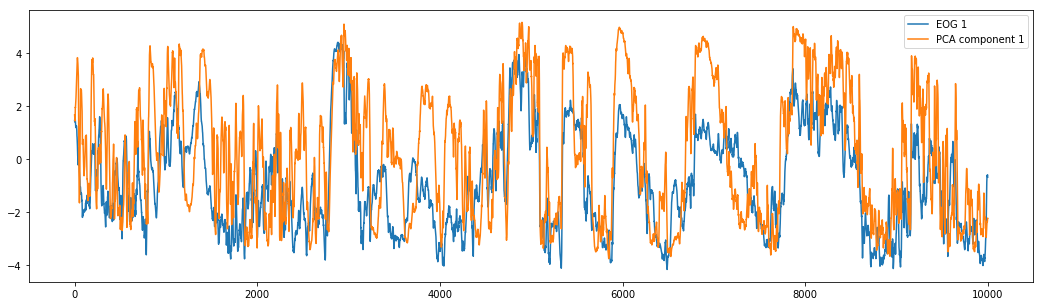

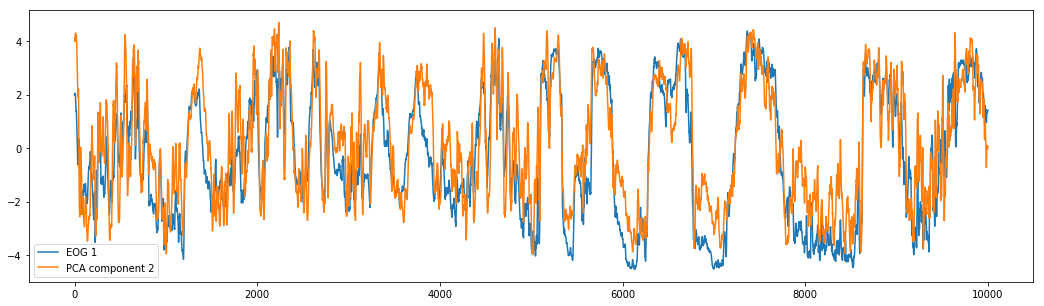

In [7]:
values = 10000

plt.figure(figsize=(18, 5))
plt.title('')
plt.plot(stage[:values,-2], label='EOG 1')
plt.plot(transformed[:values,best_eog1_comp], label=f'PCA component {best_eog1_comp}')
plt.legend()
plt.show()

plt.figure(figsize=(18, 5))
plt.plot(stage[:values,-1], label='EOG 1')
plt.plot(transformed[:values,best_eog2_comp], label=f'PCA component {best_eog2_comp}')
plt.legend()
plt.show()

In [8]:
count = 3

filtered_pca = transformed.copy()
indices_sorted = np.argsort((correlation[:,0] + correlation[:,1]).flatten())[::-1]
for index in indices_sorted[:count]:
    filtered_pca[:,index] = 0

reconstructed = pca.inverse_transform(filtered_pca)

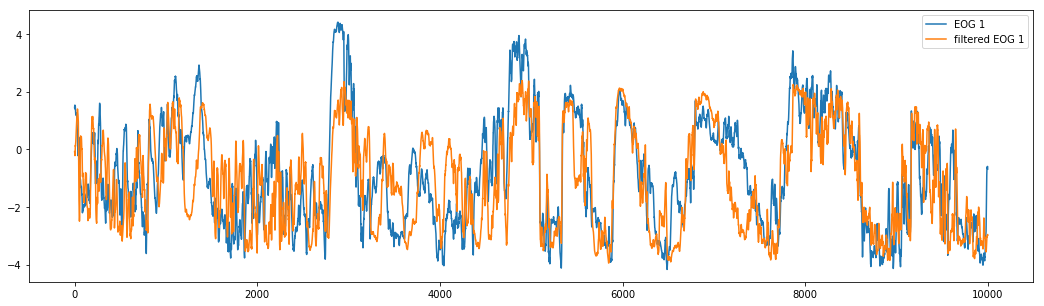

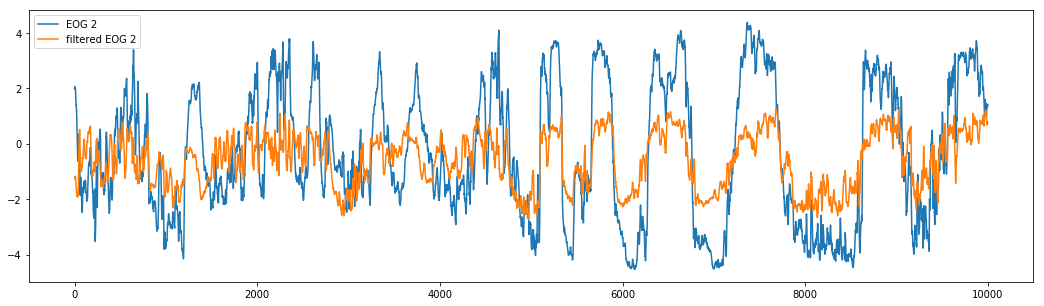

In [9]:
plt.figure(figsize=(18, 5))
plt.plot(stage[:values,-2], label='EOG 1')
plt.plot(reconstructed[:values,-2], label='filtered EOG 1')
plt.legend()
plt.show()

plt.figure(figsize=(18, 5))
plt.plot(stage[:values,-1], label='EOG 2')
plt.plot(reconstructed[:values,-1], label='filtered EOG 2')
plt.legend()
plt.show()

In [10]:
epoch_length = data[CLEAN_STAGE].shape[1]

reconstructed_epochs = np.empty(data[CLEAN_STAGE].shape)
for epoch in range(data[CLEAN_STAGE].shape[2]):
    reconstructed_epochs[:,:,epoch] = reconstructed[epoch*epoch_length:(epoch+1)*epoch_length].T

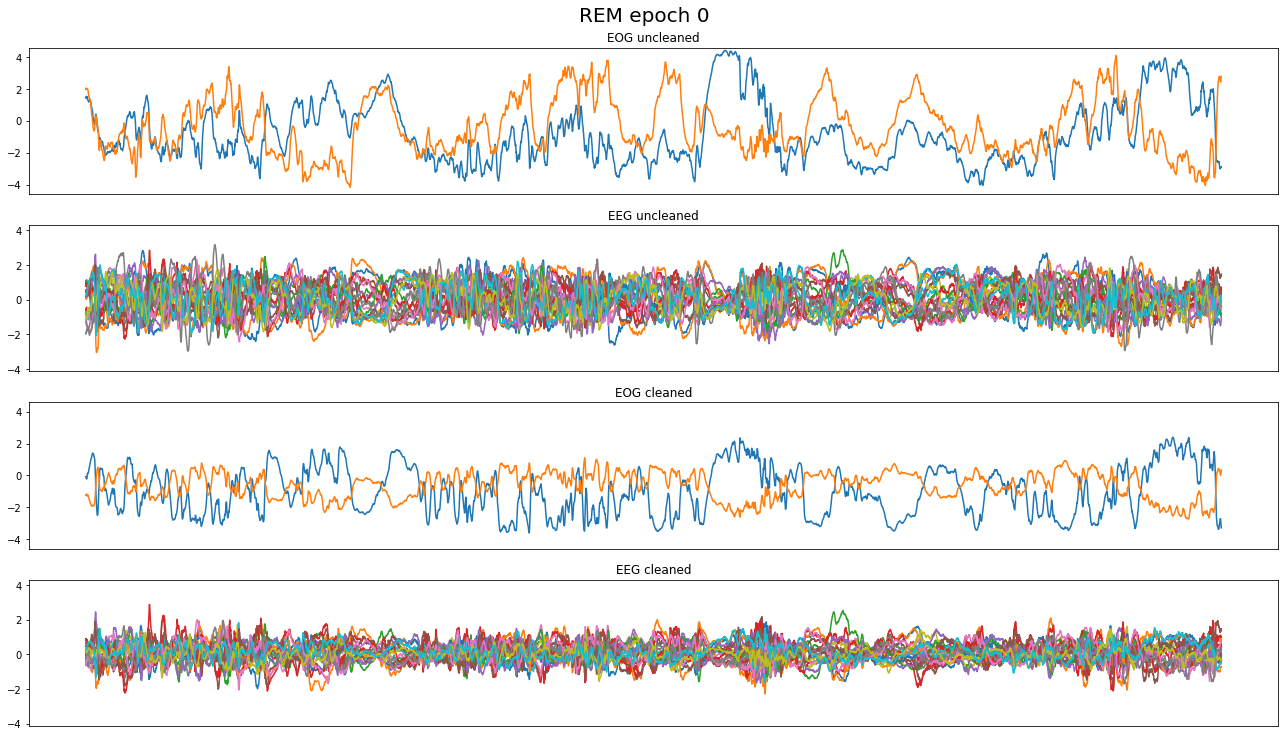

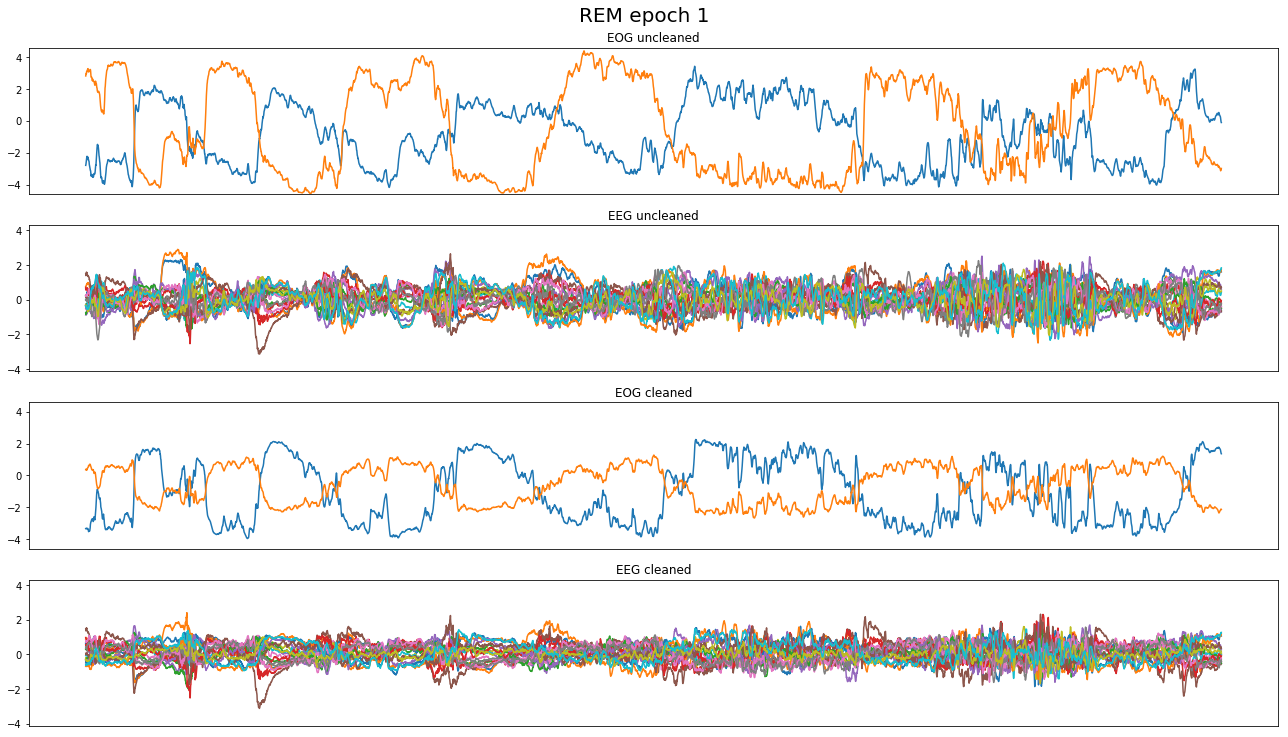

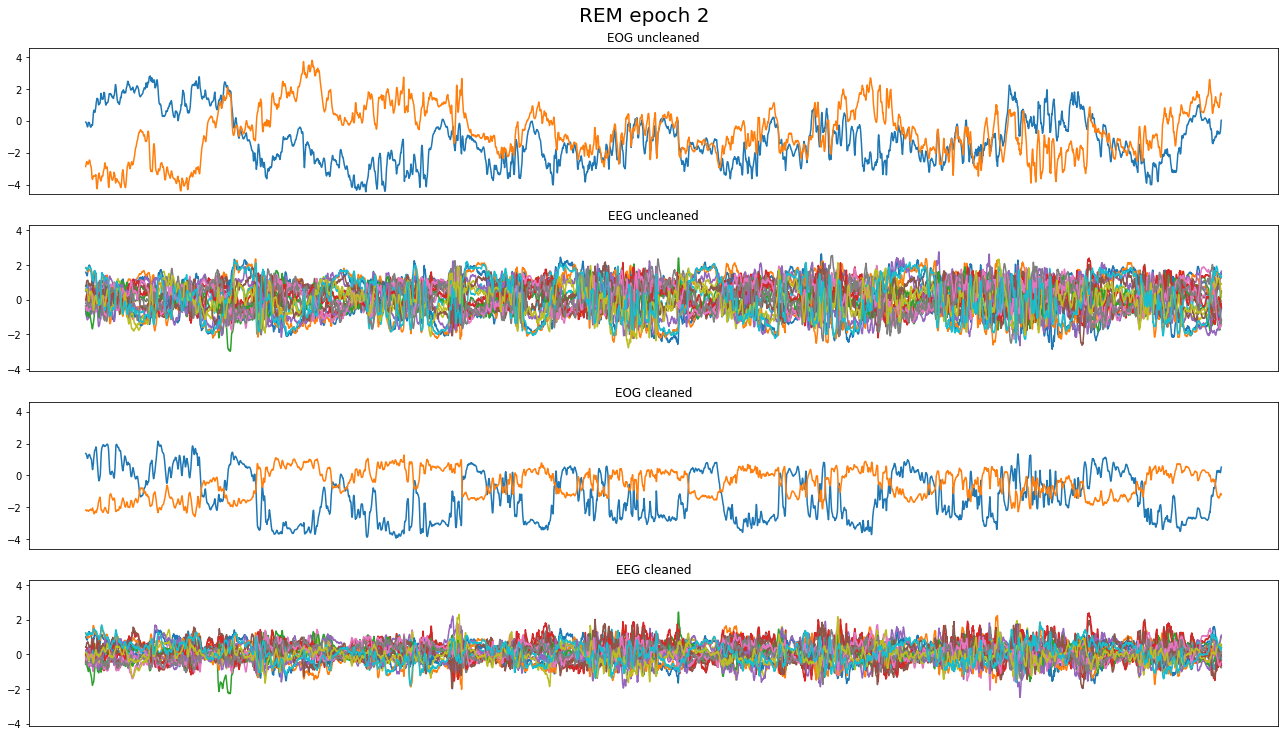

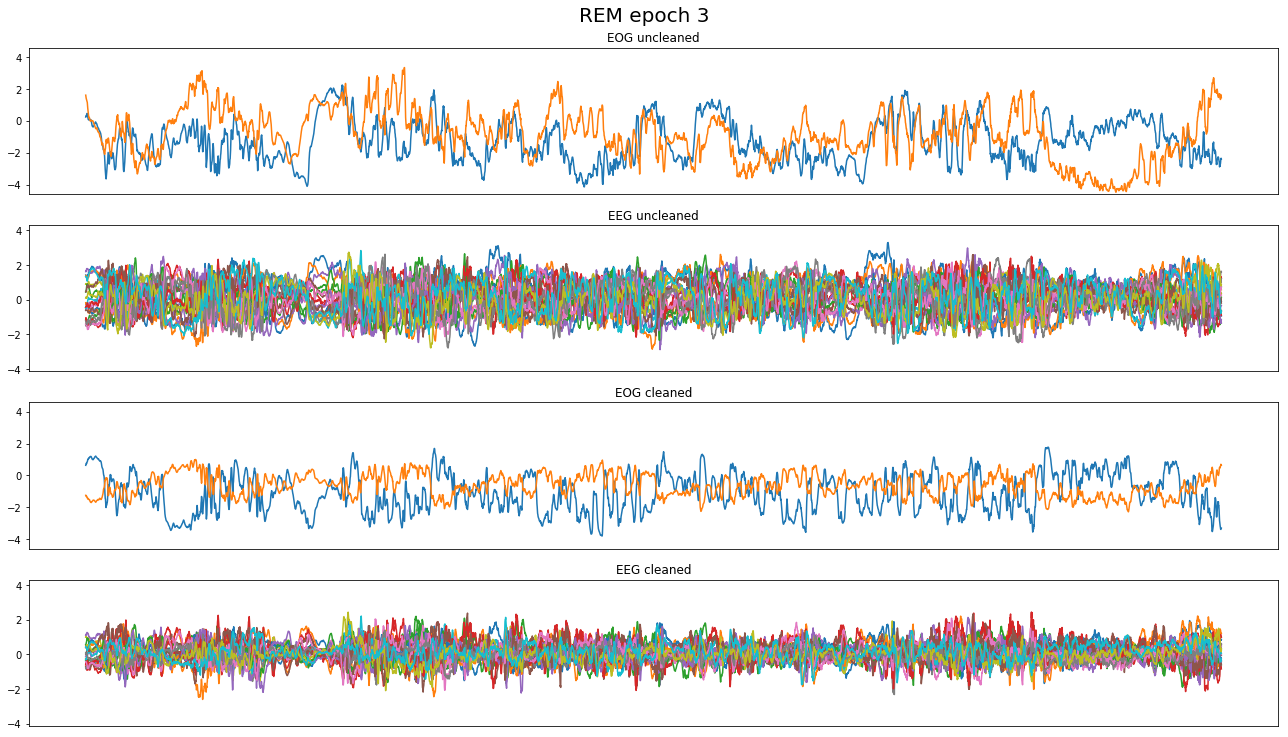

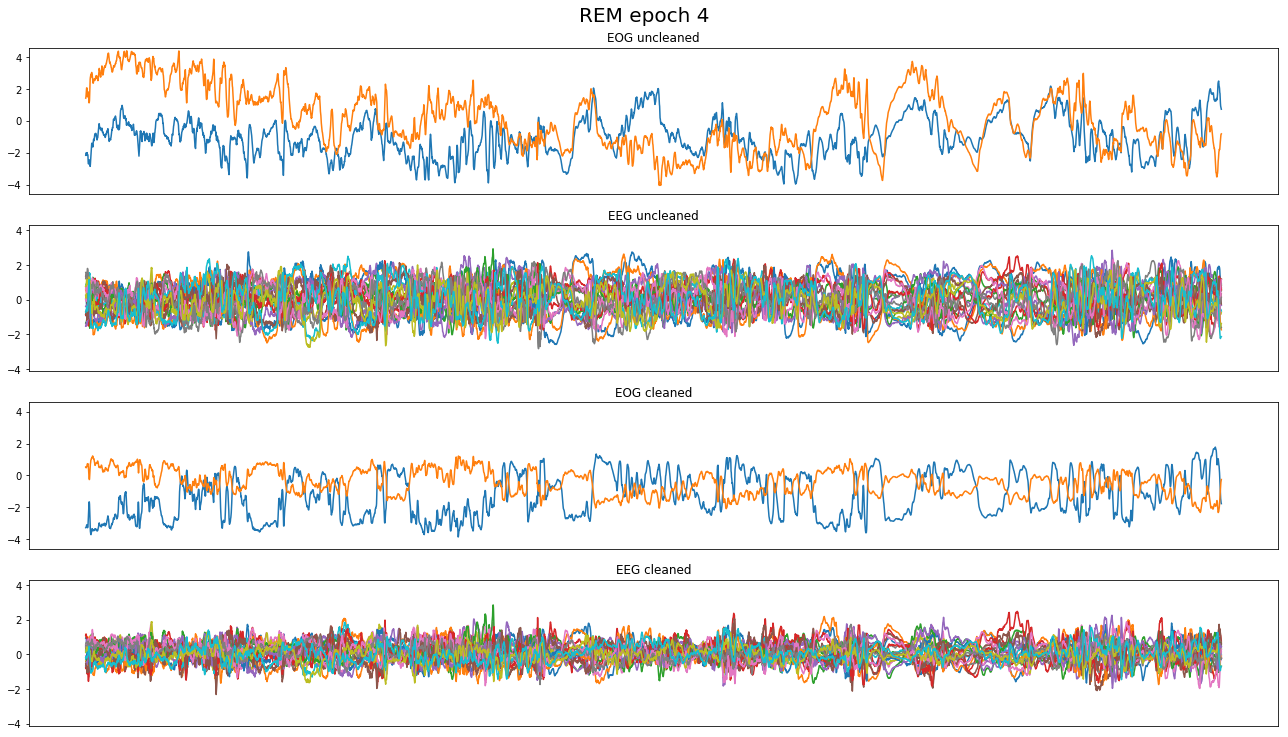

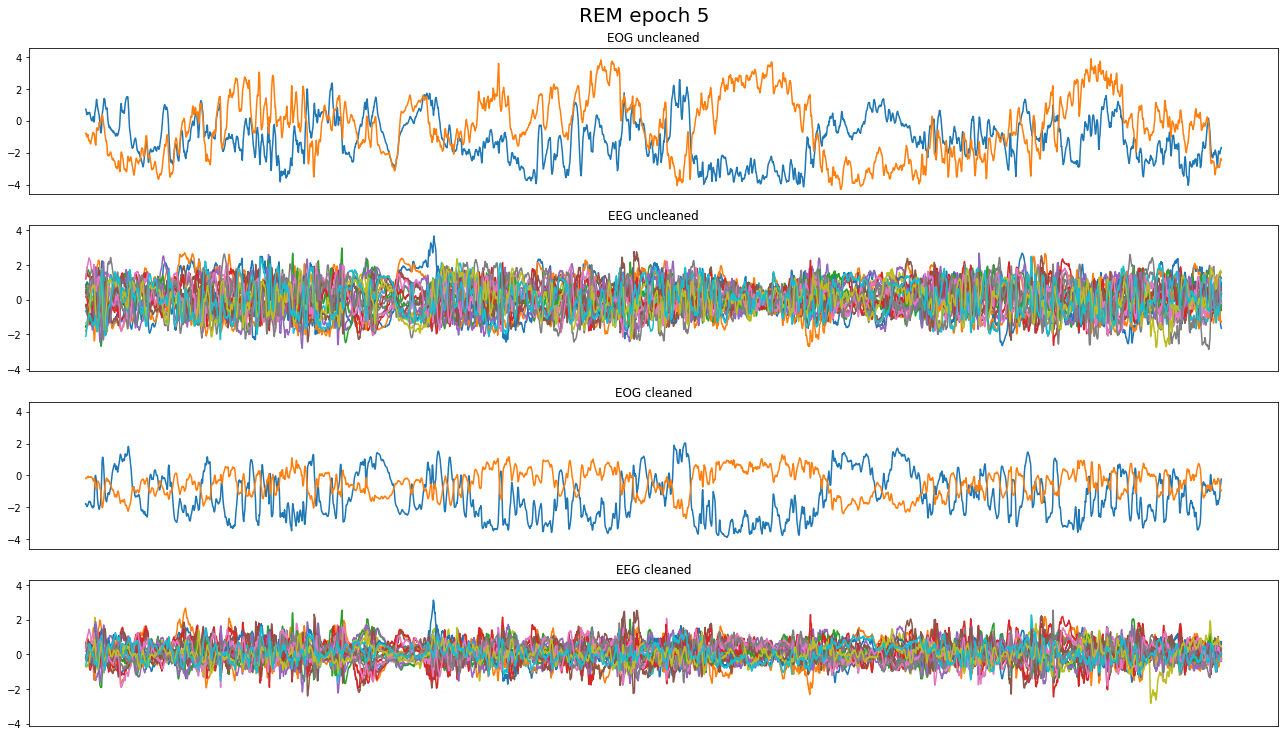

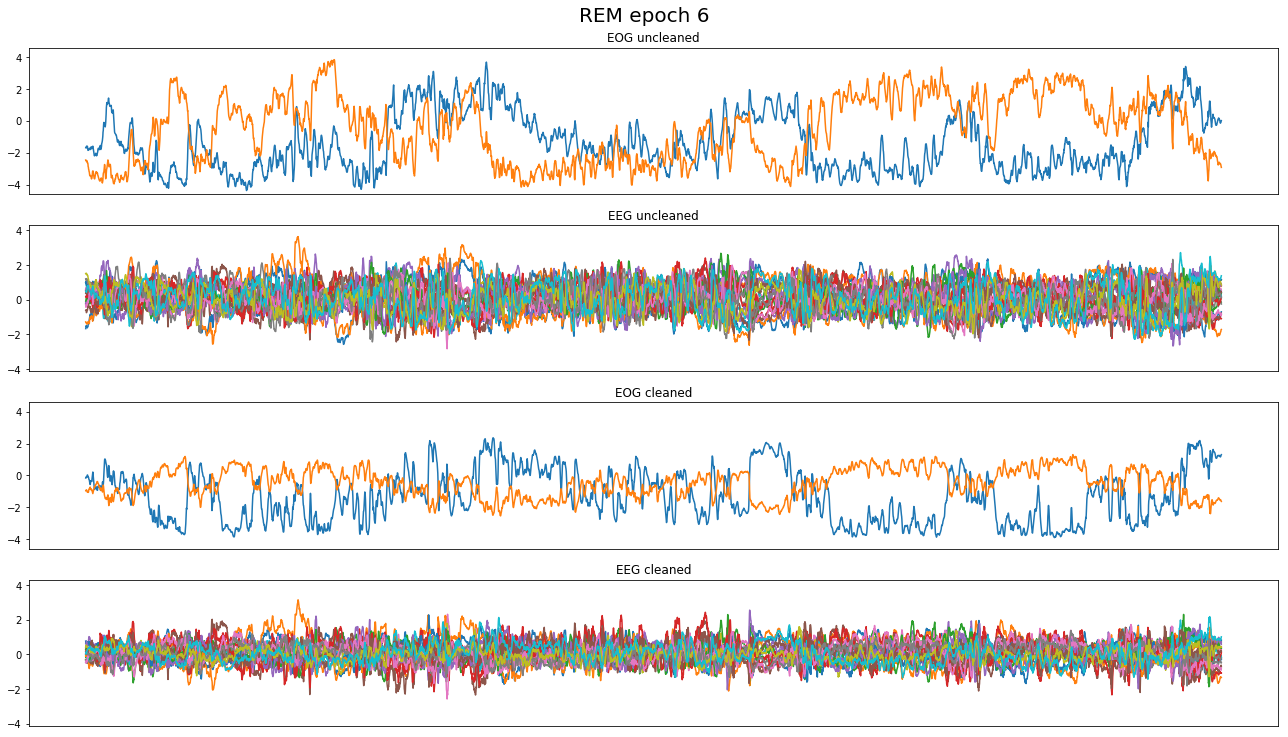

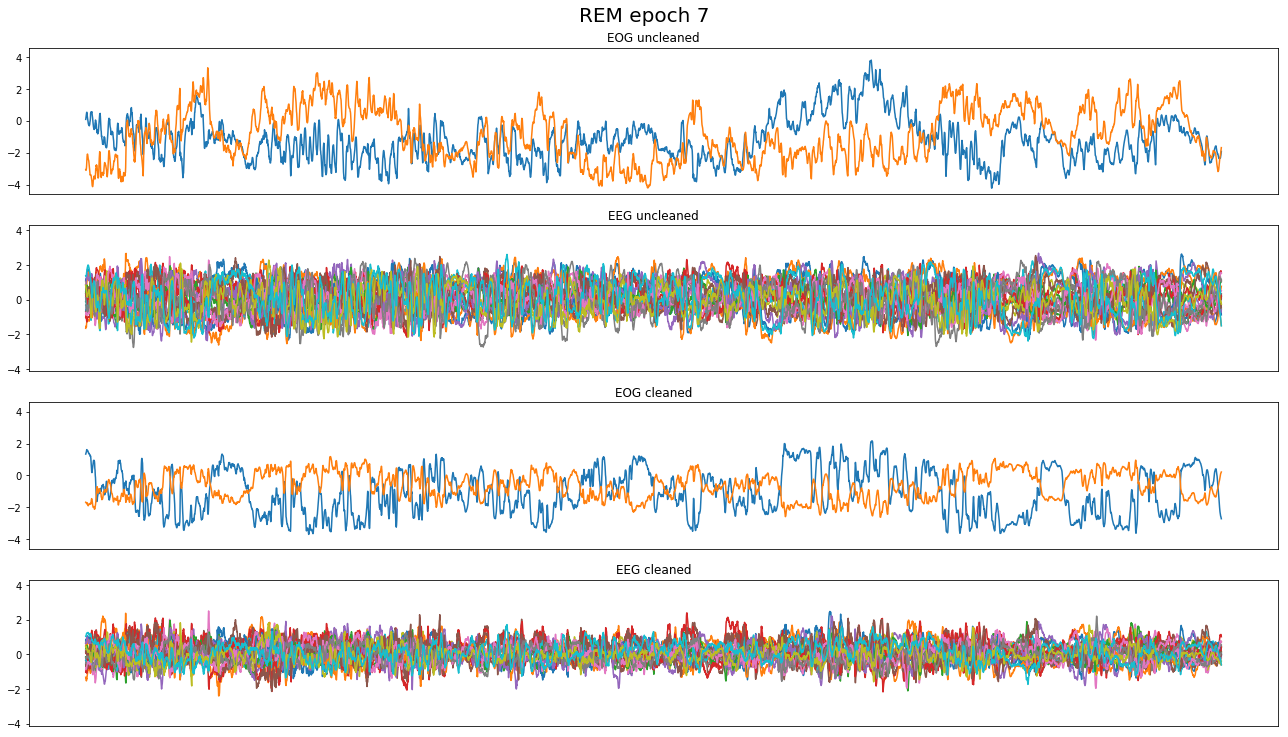

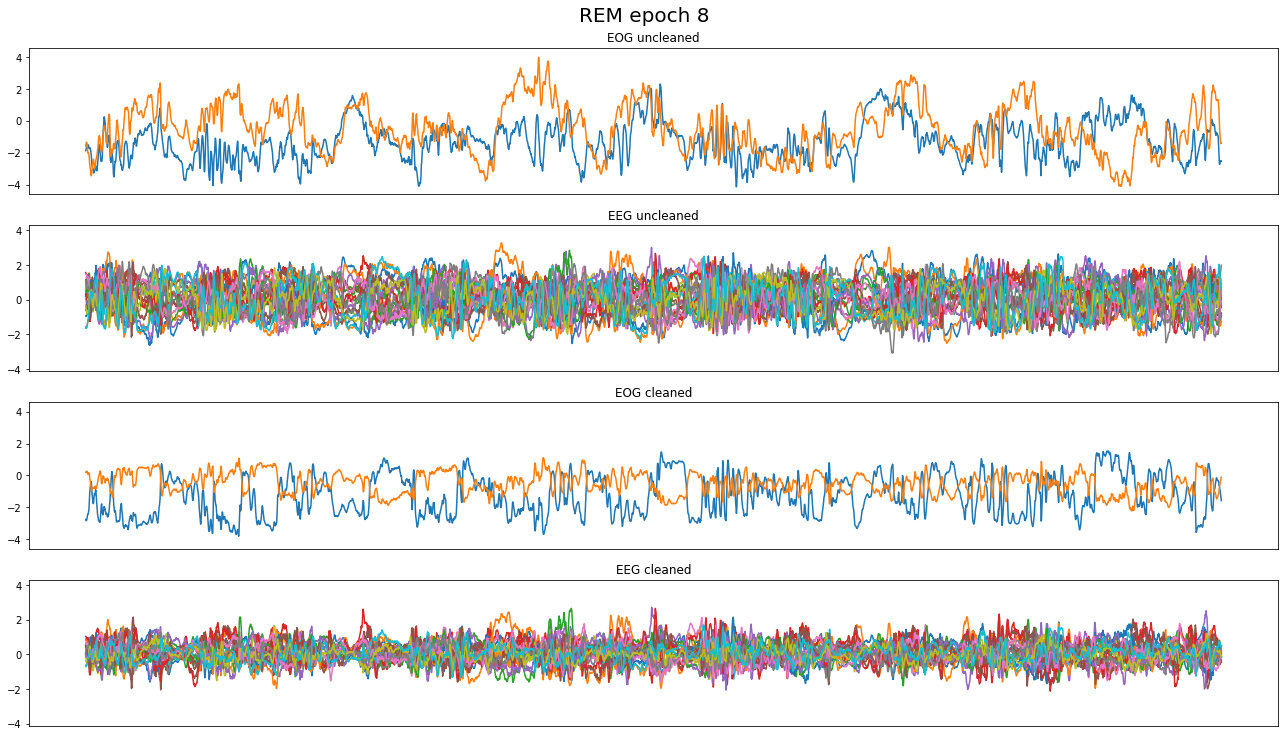

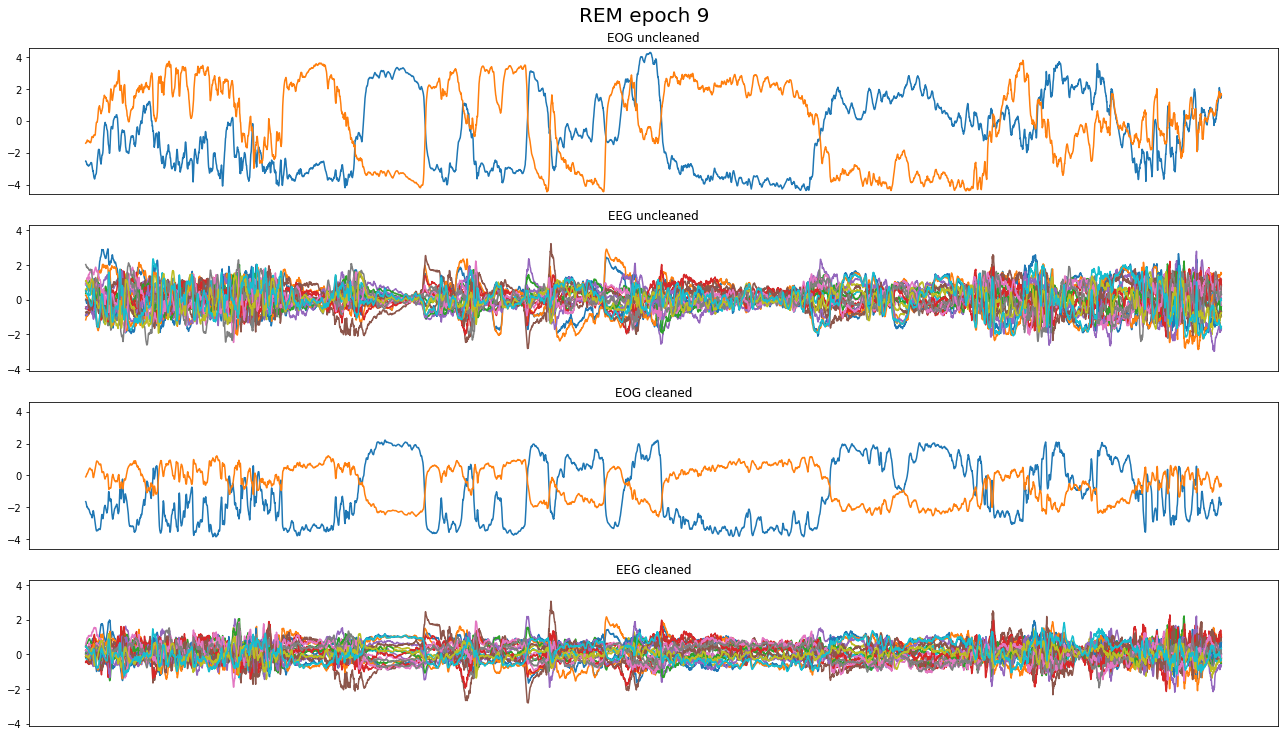

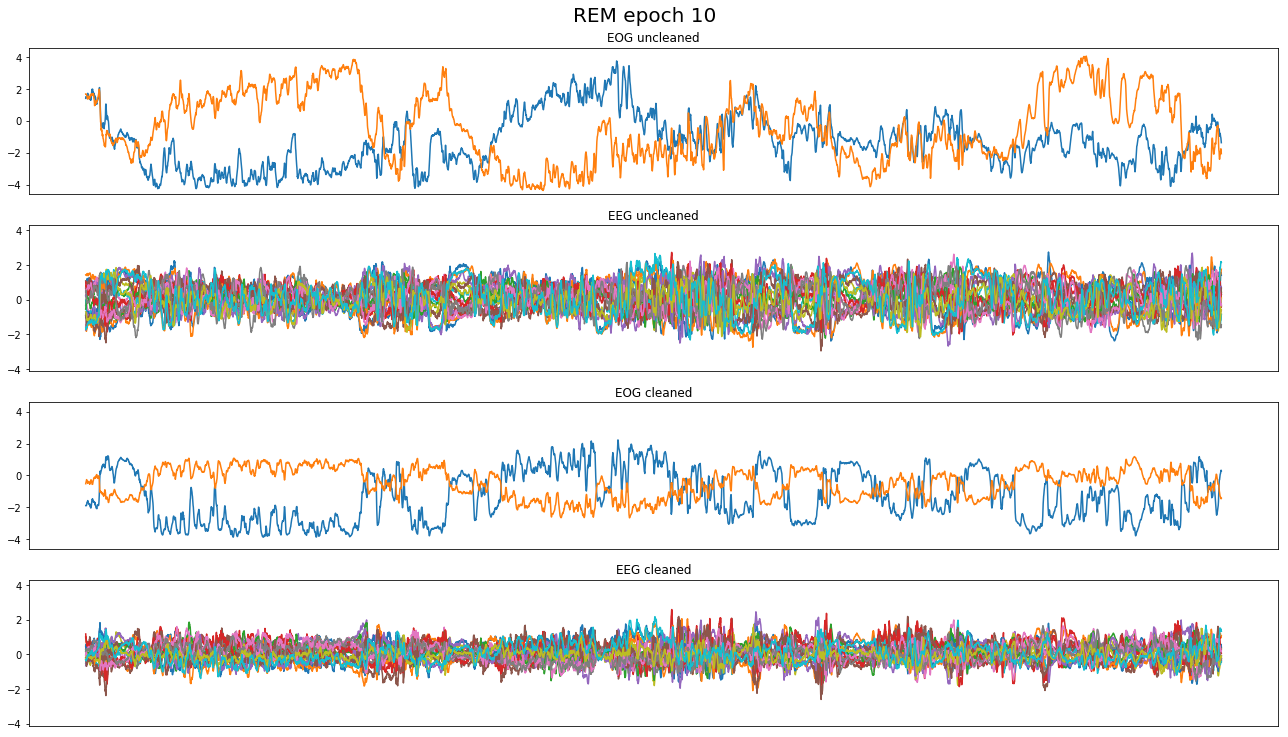

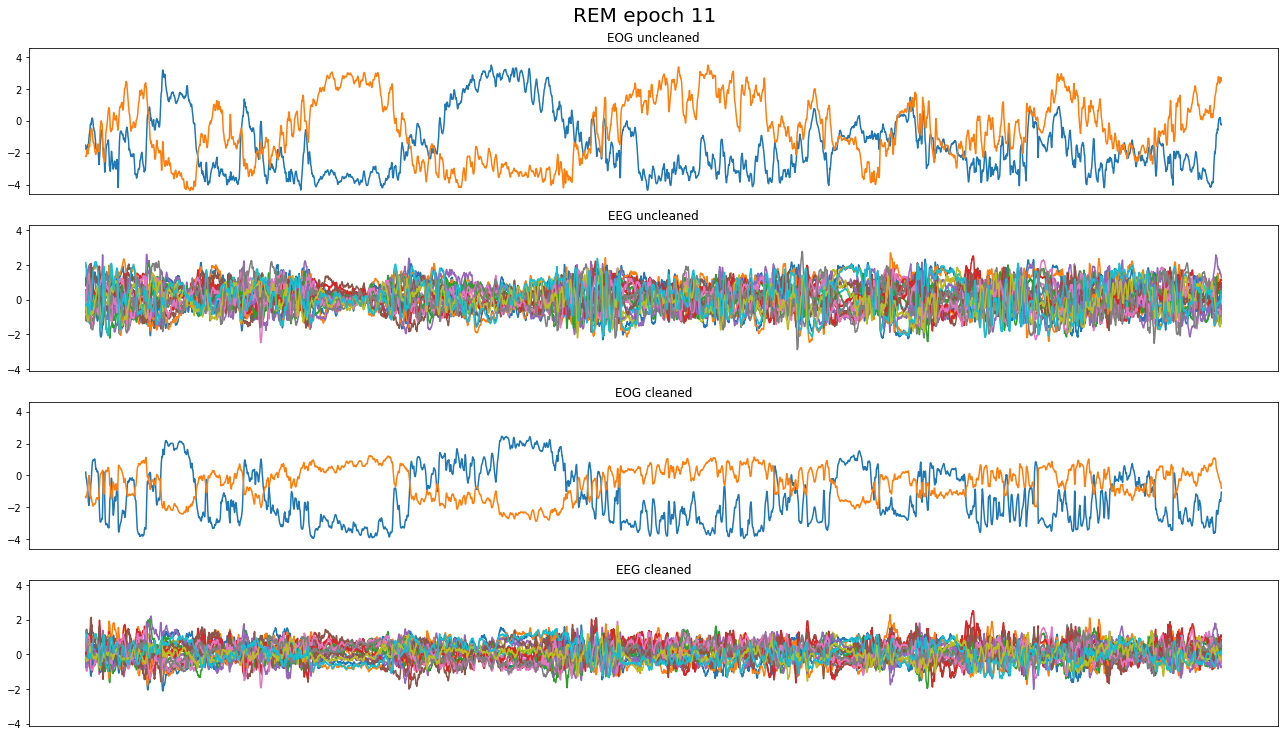

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-76e85432a118>", line 35, in <module>
    plt.show()
  File "C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\matplotlib\pyplot.py", line 251, in show
    return _show(*args, **kw)
  File "C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\ipykernel\pylab\backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\IPython\core\display.py", line 304, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\IPython\core\formatters.py", line 180, in format
    data = formatter(obj)
  File "<C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\decorator.py:deco

KeyboardInterrupt: 

In [11]:
min_eeg = np.min([normalized[:-2].min(), reconstructed_epochs[:-2].min()])
max_eeg = np.max([normalized[:-2].max(), reconstructed_epochs[:-2].max()])
min_eog = np.min([normalized[-2:].min(), reconstructed_epochs[-2:].min()])
max_eog = np.max([normalized[-2:].max(), reconstructed_epochs[-2:].max()])

for epoch in range(combined.shape[2]):
    plt.figure(figsize=(18, 10))
    plt.suptitle(f'{CLEAN_STAGE} epoch {epoch}', fontsize=20, y=1.02)
    
    ax = plt.subplot(4, 1, 1)
    plt.title('EOG uncleaned')
    plt.plot(normalized[-2:,:,epoch].T)
    plt.ylim((min_eog, max_eog))
    plt.xticks([])
    
    plt.subplot(4, 1, 2, sharex=ax)
    plt.title('EEG uncleaned')
    plt.plot(normalized[:-2,:,epoch].T)
    plt.ylim((min_eeg, max_eeg))
    plt.xticks([])
    
    plt.subplot(4, 1, 3, sharex=ax)
    plt.title('EOG cleaned')
    plt.plot(reconstructed_epochs[-2:,:,epoch].T)
    plt.ylim((min_eog, max_eog))
    plt.xticks([])
    
    plt.subplot(4, 1, 4, sharex=ax)
    plt.title('EEG cleaned')
    plt.plot(reconstructed_epochs[:-2,:,epoch].T)
    plt.ylim((min_eeg, max_eeg))
    plt.xticks([])
    
    plt.tight_layout()
    plt.show()